In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense
#BatchNormalization, Layer, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rc('font', size=20)
plt.rc('font', family = 'serif')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


2023-12-21 19:35:21.814594: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 19:35:23.958295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-12-21 19:35:23.959898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78373 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-12-21 19:35:23.961383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device

In [3]:
gauss_data = np.random.normal(0,1,100000)
gauss_sim = np.random.normal(-0.5,1,100000)

In [4]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

In [6]:
losses = []
for lambda1 in np.linspace(-1,1,20):
    print(f"{lambda1 = }")

    xvals_1 = np.concatenate([gauss_data,gauss_sim])
    yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
    weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=0)
    losses+=[model.history.history['loss'][-1]]

lambda1 = -1.0
lambda1 = -0.8947368421052632
lambda1 = -0.7894736842105263
lambda1 = -0.6842105263157895
lambda1 = -0.5789473684210527
lambda1 = -0.4736842105263158
lambda1 = -0.368421052631579
lambda1 = -0.26315789473684215
lambda1 = -0.1578947368421053
lambda1 = -0.052631578947368474
lambda1 = 0.05263157894736836
lambda1 = 0.1578947368421053
lambda1 = 0.26315789473684204
lambda1 = 0.36842105263157876
lambda1 = 0.4736842105263157
lambda1 = 0.5789473684210527
lambda1 = 0.6842105263157894
lambda1 = 0.7894736842105261
lambda1 = 0.894736842105263
lambda1 = 1.0


In [7]:
np.save('npfiles/gaussloss', losses)

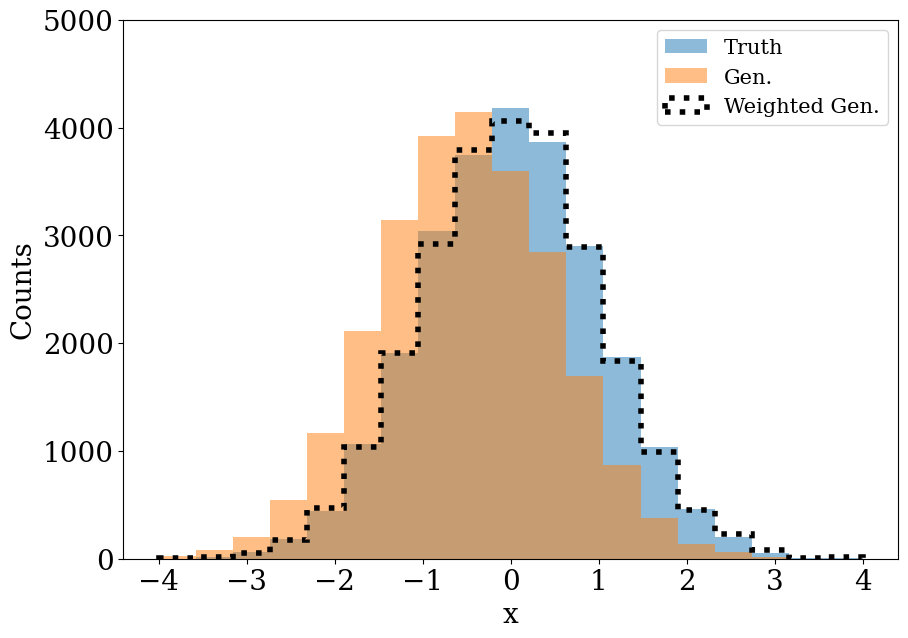

In [22]:
#plots with hand inserted lambda
lambda1 = 0.5
c = 'black'

xvals_1 = np.concatenate([gauss_data,gauss_sim])
yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

fig, ax = plt.subplots(figsize=(10, 7))

ax.xaxis.label.set_color(c)        
ax.yaxis.label.set_color(c)          
ax.tick_params(axis='x', colors=c)  
ax.tick_params(axis='y', colors=c)  
ax.spines['left'].set_color(c)        
ax.spines['top'].set_color(c)
ax.spines['right'].set_color(c) 
ax.spines['bottom'].set_color(c) 

_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=np.linspace(-4,4,20),alpha=0.5,label="Truth")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),alpha=0.5,label="Gen.")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),weights=w_test_1[Y_test_1==0],histtype="step",color=c,ls=":", lw=4,label="Weighted Gen.")
plt.legend(fontsize=15)
plt.ylim([0,5000])
plt.xlabel("x")
plt.ylabel("Counts")
plt.savefig("gaussexample.pdf", bbox_inches='tight', transparent=True)
plt.show()

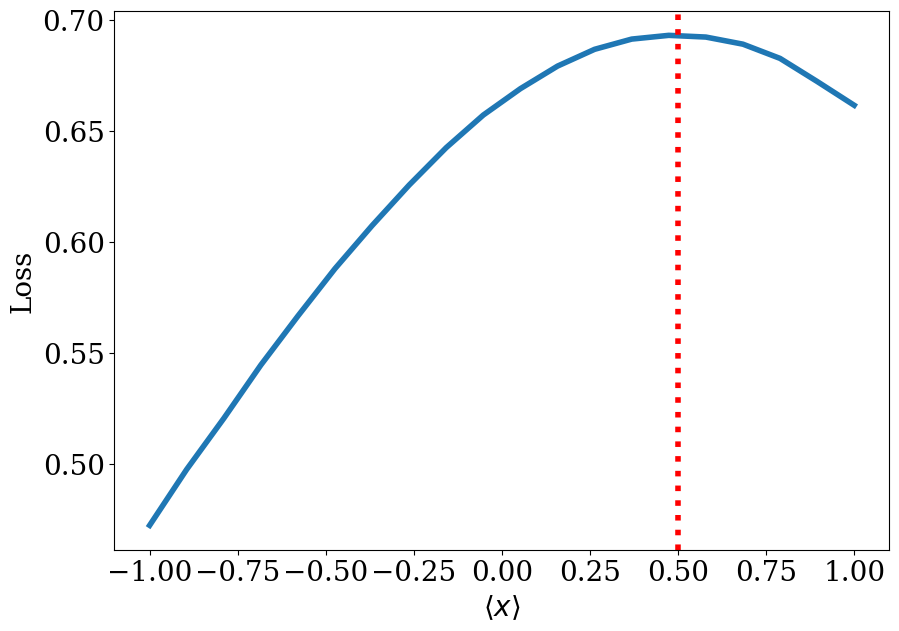

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.xaxis.label.set_color(c)        
ax.yaxis.label.set_color(c)          
ax.tick_params(axis='x', colors=c)  
ax.tick_params(axis='y', colors=c)  
ax.spines['left'].set_color(c)        
ax.spines['top'].set_color(c)
ax.spines['right'].set_color(c) 
ax.spines['bottom'].set_color(c) 

plt.plot(np.linspace(-1,1,20),losses, lw=4)
plt.axvline(1/2, color="r",ls=":", lw=4)
plt.ylabel("Loss")
plt.xlabel(r"$\langle x \rangle$")
plt.savefig("gaussloss.pdf", bbox_inches='tight',  transparent=True)

plt.show()